# Adversarial Autoencoder

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

Let's load the MNIST data set.

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Create a *loader* to feed the data batch by batch during training.

In [3]:
batch = 100
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch, shuffle=True)

Now, we define the **autoencoder** as well as the **discriminator**.

In [4]:
input_dim = 28 * 28
z_dim = 2 # dimension of the low-dimensional code / representation
hidden_dim = 128 # hidden layer (encoder/decoder)

hidden_dim_d = 128 # hidden layer (discriminator)
output_dim_d = 1

# autoencoder
encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim))

decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid())

autoencoder = nn.Sequential(
            encoder,
            decoder)


# discriminator
discriminator = nn.Sequential(
            nn.Linear(z_dim, hidden_dim_d),
            nn.ReLU(),
            nn.Linear(hidden_dim_d, output_dim_d),
            nn.Sigmoid())

We define the loss function and optimization schemes (here **Adam**) for the autoencoder and the discriminator.

In [5]:
lr = 0.001 # learning rate
criterion = nn.BCELoss()
optimizer_ae = torch.optim.Adam(params=autoencoder.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=lr)
optimizer_g = torch.optim.Adam(params=encoder.parameters(), lr=lr)

Finally, we train the adversarial autoencoder.

In [6]:
epochs = 10
data_size = int(mnist.train_labels.size()[0])

for i in range(epochs):
    for j, (images, _) in enumerate(data_loader):
        images = images.view(batch, -1) # map tensor from [batch, 1, 28, 28] to [batch, 28 * 28]
        images = Variable(images)

        # Autoencoder step
        autoencoder.zero_grad()
        reconstructions = autoencoder(images)
        loss_ae = torch.dist(images, reconstructions)
        loss_ae.backward()
        optimizer_ae.step()

        # Discriminator step
        discriminator.zero_grad()
        z_fake = encoder(images.detach())
        z_real = Variable(torch.randn(z_fake.size()))
        z_fake_d = discriminator(z_fake)
        z_real_d = discriminator(z_real)

        loss_real = criterion(z_real_d, Variable(torch.ones(z_real_d.size())))
        loss_fake = criterion(z_fake_d, Variable(torch.zeros(z_fake_d.size())))
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Generator (encoder) step
        encoder.zero_grad()
        discriminator
        z_fake = encoder(images)
        z_fake_d = discriminator(z_fake)
        loss_g = criterion(z_fake_d, Variable(torch.ones(z_fake_d.size())))
        loss_g.backward()
        optimizer_g.step()
        if j % 100 == 0:
            print('Epoch %i/%i [%i/%i] loss_ae: %.2f, D(z_real)=%.2f, D(E(x))=%.2f' % (i + 1, epochs, j,
                            data_size / float(batch), loss_ae.data[0], z_real_d.mean().data[0],
                            z_fake_d.mean().data[0]))

Epoch 1/10 [0/600] loss_ae: 135.15, D(z_real)=0.60, D(E(x))=0.60
Epoch 1/10 [100/600] loss_ae: 73.38, D(z_real)=0.70, D(E(x))=0.19
Epoch 1/10 [200/600] loss_ae: 68.76, D(z_real)=0.69, D(E(x))=0.34
Epoch 1/10 [300/600] loss_ae: 69.13, D(z_real)=0.68, D(E(x))=0.38
Epoch 1/10 [400/600] loss_ae: 65.62, D(z_real)=0.66, D(E(x))=0.40
Epoch 1/10 [500/600] loss_ae: 62.80, D(z_real)=0.61, D(E(x))=0.41
Epoch 2/10 [0/600] loss_ae: 62.34, D(z_real)=0.53, D(E(x))=0.42
Epoch 2/10 [100/600] loss_ae: 63.25, D(z_real)=0.53, D(E(x))=0.45
Epoch 2/10 [200/600] loss_ae: 63.17, D(z_real)=0.52, D(E(x))=0.48
Epoch 2/10 [300/600] loss_ae: 64.82, D(z_real)=0.53, D(E(x))=0.48
Epoch 2/10 [400/600] loss_ae: 61.04, D(z_real)=0.52, D(E(x))=0.46
Epoch 2/10 [500/600] loss_ae: 63.02, D(z_real)=0.52, D(E(x))=0.49
Epoch 3/10 [0/600] loss_ae: 64.93, D(z_real)=0.54, D(E(x))=0.47
Epoch 3/10 [100/600] loss_ae: 65.15, D(z_real)=0.56, D(E(x))=0.46
Epoch 3/10 [200/600] loss_ae: 72.47, D(z_real)=0.51, D(E(x))=0.42
Epoch 3/10 [300

Let's plot some images along their reconstructions.

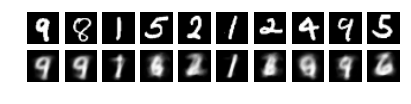

In [8]:
images = images.view(batch, 28, 28).data.numpy()
reconstructions = reconstructions.view(batch, 28, 28).data.numpy()

fig = plt.figure(figsize=(6, 6))
for i in range(10):
    a = fig.add_subplot(10, 10, i + 1)
    b = fig.add_subplot(10, 10, i + 11)
    a.axis('off')
    b.axis('off')
    image = images[i - 1]
    reconstruction = reconstructions[i - 1]
    a.imshow(image, cmap='Greys_r')
    b.imshow(reconstruction, cmap='Greys_r');

The low-dimensional representation is suppose to follow a standard Gaussian distribution. Let's check it!

In [63]:
n_samples = 10000
data = Variable(mnist.train_data[:n_samples].view(n_samples, -1).float() / 255.)
labels = mnist.train_labels[:n_samples]
code = encoder(data)

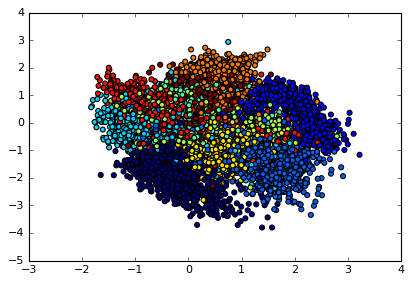

In [64]:
plt.scatter(*zip(*code.data.numpy()), c=labels.numpy());